# Домашнее задание "Методология ведения DS-проектов"
Возьмите задачу с винами (www.kaggle.com...ne-quality) и решите ее, оформив в виде CrispDM-подхода. Решение - jupyter notebook на github или colab.

# 1. Понимание бизнеса

## 1.1 Цель
Предсказать качество/свойства вин

## 1.2 Описание
Об этом файле. Данные были загружены из репозитория машинного обучения UCI.

Два набора данных относятся к красному и белому вариантам португальского вина «Vinho Verde». Подробнее см. в ссылке [Cortez et al., 2009]. Из-за проблем с конфиденциальностью и логистикой доступны только физико-химические (входные) и органолептические (выходные) переменные (например, нет данных о сортах винограда, марке вина, продажной цене вина и т. д.).

Эти наборы данных можно рассматривать как задачи классификации или регрессии. Классы упорядочены и не сбалансированы (например, нормальных вин гораздо больше, чем отличных или плохих). Алгоритмы обнаружения выбросов можно использовать для определения нескольких отличных или плохих вин.

Входные переменные (на основе физико-химических тестов):
1 - фиксированная кислотность
2 - летучая кислотность
3 - лимонная кислота
4 - остаточный сахар
5 - хлориды
6 - свободный диоксид серы
7 - диоксид серы общий
8 - плотность
9 - рН
10 - сульфаты
11 - алкоголь
Выходная переменная (на основе сенсорных данных):
12 - качество (оценка от 0 до 10)

# 2. Data Understanding Пониманиие данных

## 2.1 Import Libraries Импорт библиотек

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

## 2.2 Вспомогательные функции

In [2]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    

## 2.3 Загрузка данных

In [3]:
#pd.read_csv
df_1 = pd.read_csv('winequalityN.csv')

In [4]:
#head()
df_1.head(10)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
6,white,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6
7,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
8,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
9,white,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,6


In [5]:
#shape
df_1.shape

(6497, 13)

Набор данных состоит из 6497 наблюдений и 12 характеристик, из которых одна является зависимой переменной, а остальные 11 являются независимыми переменными - физико-химическими характеристиками

## 2.4 Статистика и визуализации

In [6]:
#columns.values
df_1.columns.values

array(['type', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'], dtype=object)

In [7]:
#info() 
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
type                    6497 non-null object
fixed acidity           6487 non-null float64
volatile acidity        6489 non-null float64
citric acid             6494 non-null float64
residual sugar          6495 non-null float64
chlorides               6495 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6488 non-null float64
sulphates               6493 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [8]:
#isnull()
df_1.isnull()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,False,False,False,False,False,False,False,False,False,False,False,False,False
6493,False,False,False,False,False,False,False,False,False,False,True,False,False
6494,False,False,False,False,False,False,False,False,False,False,False,False,False
6495,False,False,False,False,False,False,False,False,False,False,False,False,False


In [9]:
#isnull().sum()
df_1.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

В значениях 7 переменных есть нули

In [10]:
df_1['type'].value_counts()

white    4898
red      1599
Name: type, dtype: int64

### 2.4.1 Далее взглянем на некоторую ключевую информацию о переменных
Числовая переменная - это переменная со значениями в области целых или действительных чисел, в то время как категориальная переменная - это переменная, которая может принимать одно из ограниченного и обычно фиксированного числа возможных значений

In [11]:
#describe()
df_1.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


Заметно большая разница в 75%-м и максимальном значениях предикторов "остаточный сахар", "свободный диоксид серы", "общий диоксид серы". Наблюдение предполагает, что в наборе данных есть экстремальные значения — выбросы.

Некоторые вина слабые, т.е. алкоголь <10.
Некоторые вина соленые, т.е. хлориды >0,06.
Брожение не закончилось для некоторых вин, т.е. плотность >1.
Некоторые вина более кислотные, чем другие, так как средний показатель составляет 3,21, а максимальный - 4,01.
Некоторые вина сладкие, т.е. остаточный сахар > 5.

In [12]:
df_1['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

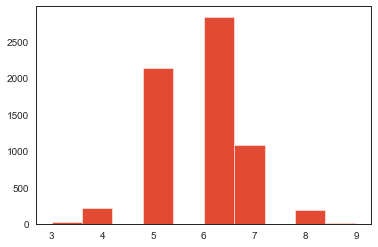

In [13]:
plt.hist(df_1['quality'])
plt.show()

Более всего вин с качественной оценкой 6. 5 вин с максимальной оценкой 9. 30 с минимальной оценкой 3.

### 2.4.2 Тепловая карта корреляции может дать нам понимание того, какие переменные важны

(12.0, 0.0)

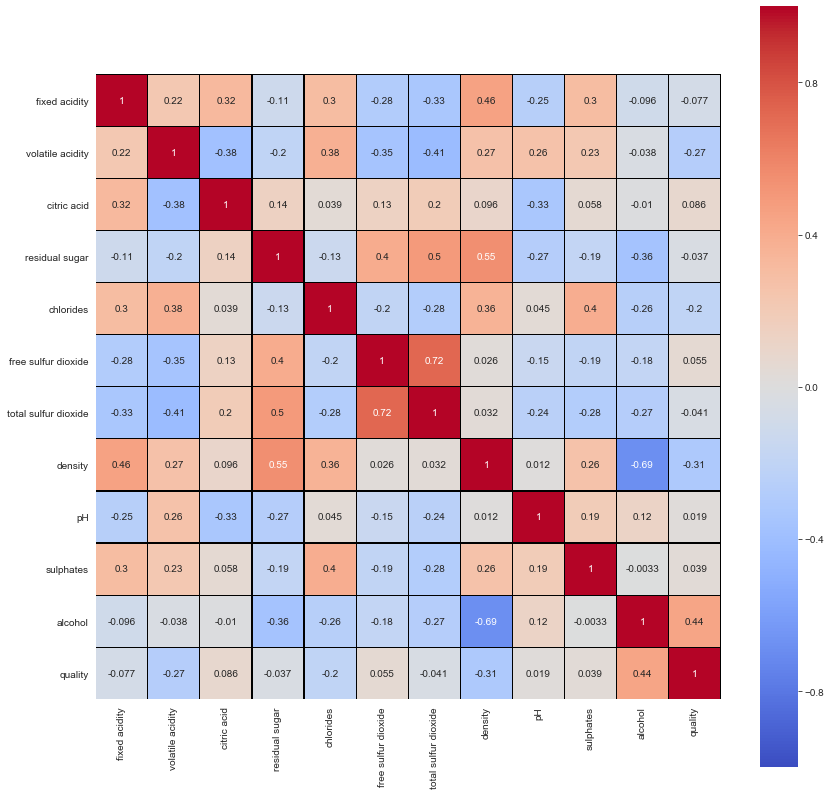

In [14]:
plt.figure(figsize=(14,14))

mp=sns.heatmap(df_1.corr(), annot = True,cmap='coolwarm',
            vmin=-1, vmax=1, center=0,linewidths=0.2,linecolor='black',
            cbar=True,square=True)
bottom, top = mp.get_ylim()
mp.set_ylim(bottom + 0.5, top - 0.5)

Качество вина сильно зависит от содержания алкоголя, летучих кислот.
качество и алкоголь положительно коррелируют.
Лимонная кислота и качество имеют отрицательную корреляцию.
Здесь мы можем сделать вывод, что «плотность» имеет сильную положительную корреляцию с «остаточным сахаром», тогда как она имеет сильную отрицательную корреляцию с «алкоголем».
    "свободный диоксид серы" и "лимонная кислота" почти не имеют корреляции с "качеством"

### 2.4.3 Давайте подробнее рассмотрим взаимосвязь между признаками 
Распределения качества белового и красного вина по количеству алкоголя и диоксида серы 
Рассмотрите дополнительно влияние 2х других признаков

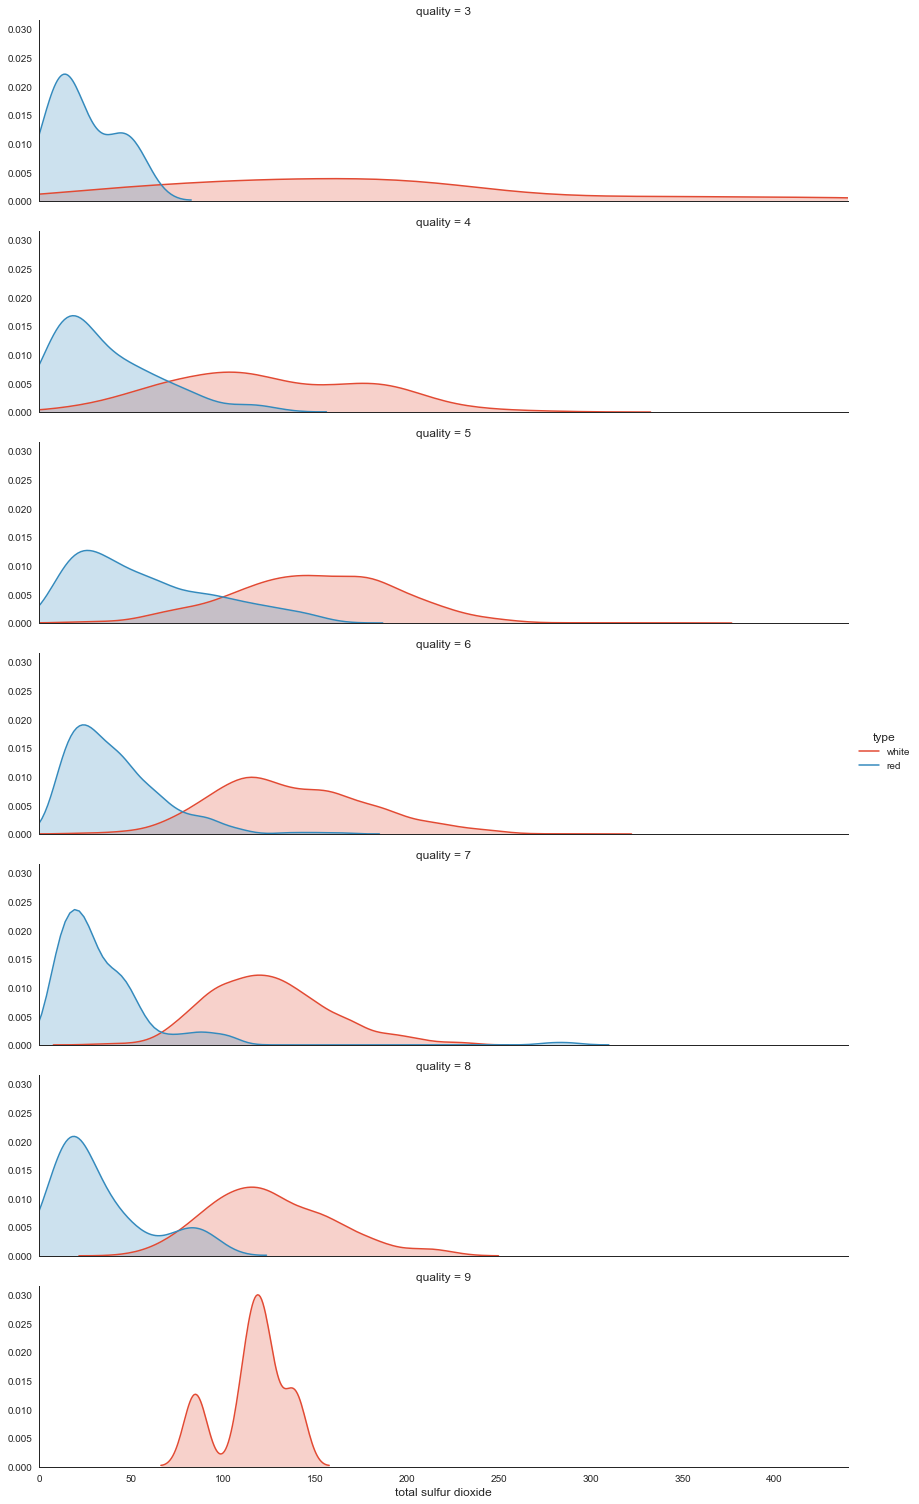

In [15]:
plot_distribution( df_1 , var = 'total sulfur dioxide' , target = 'type' , row = 'quality' )

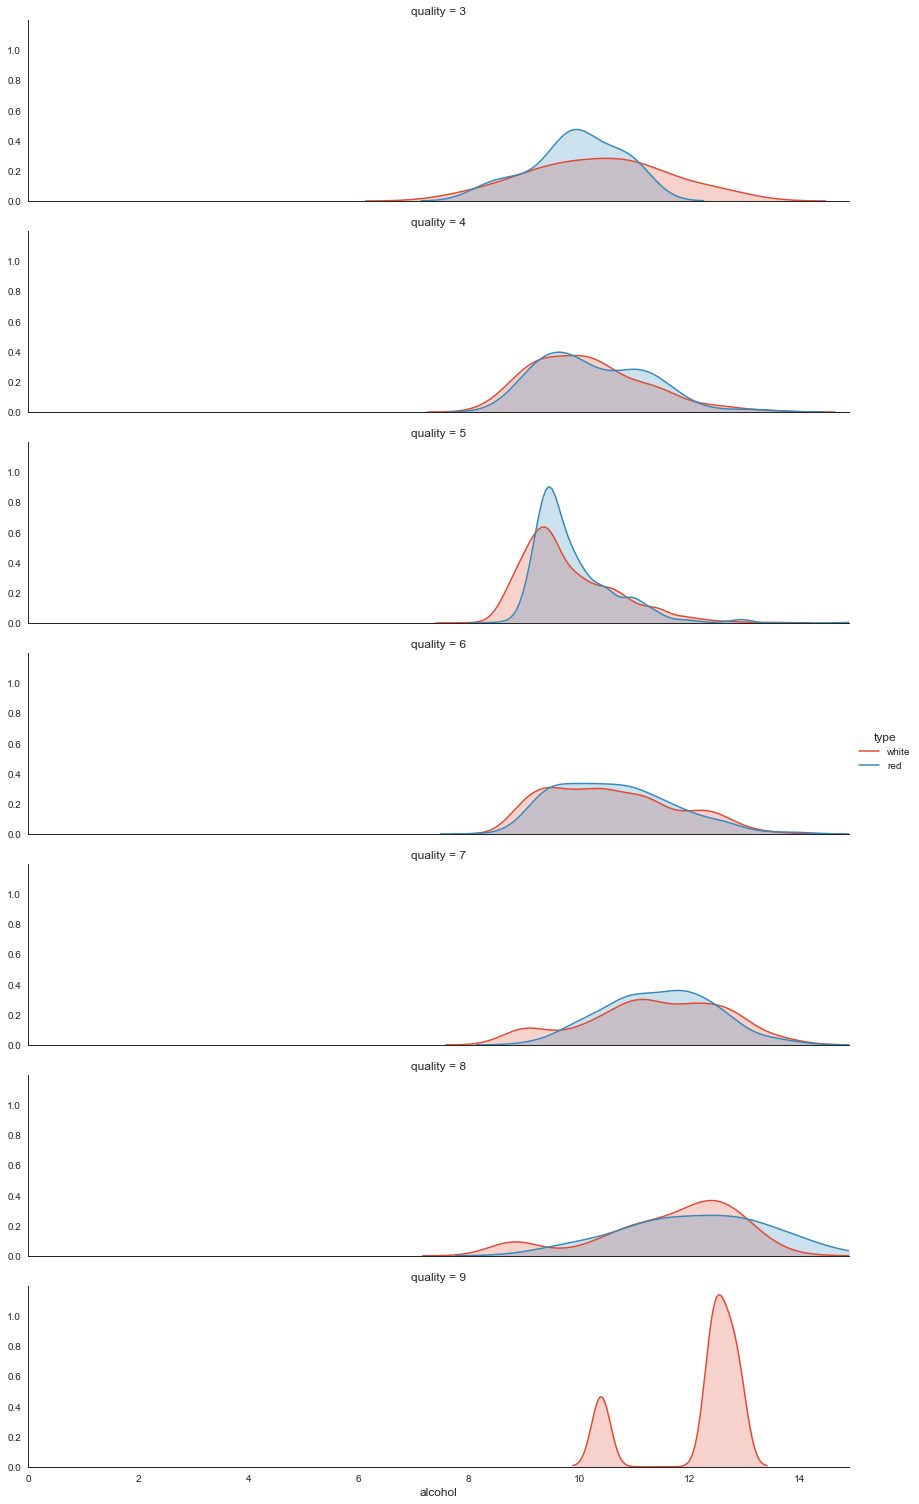

In [16]:
plot_distribution( df_1 , var = 'alcohol' , target = 'type' , row = 'quality' )

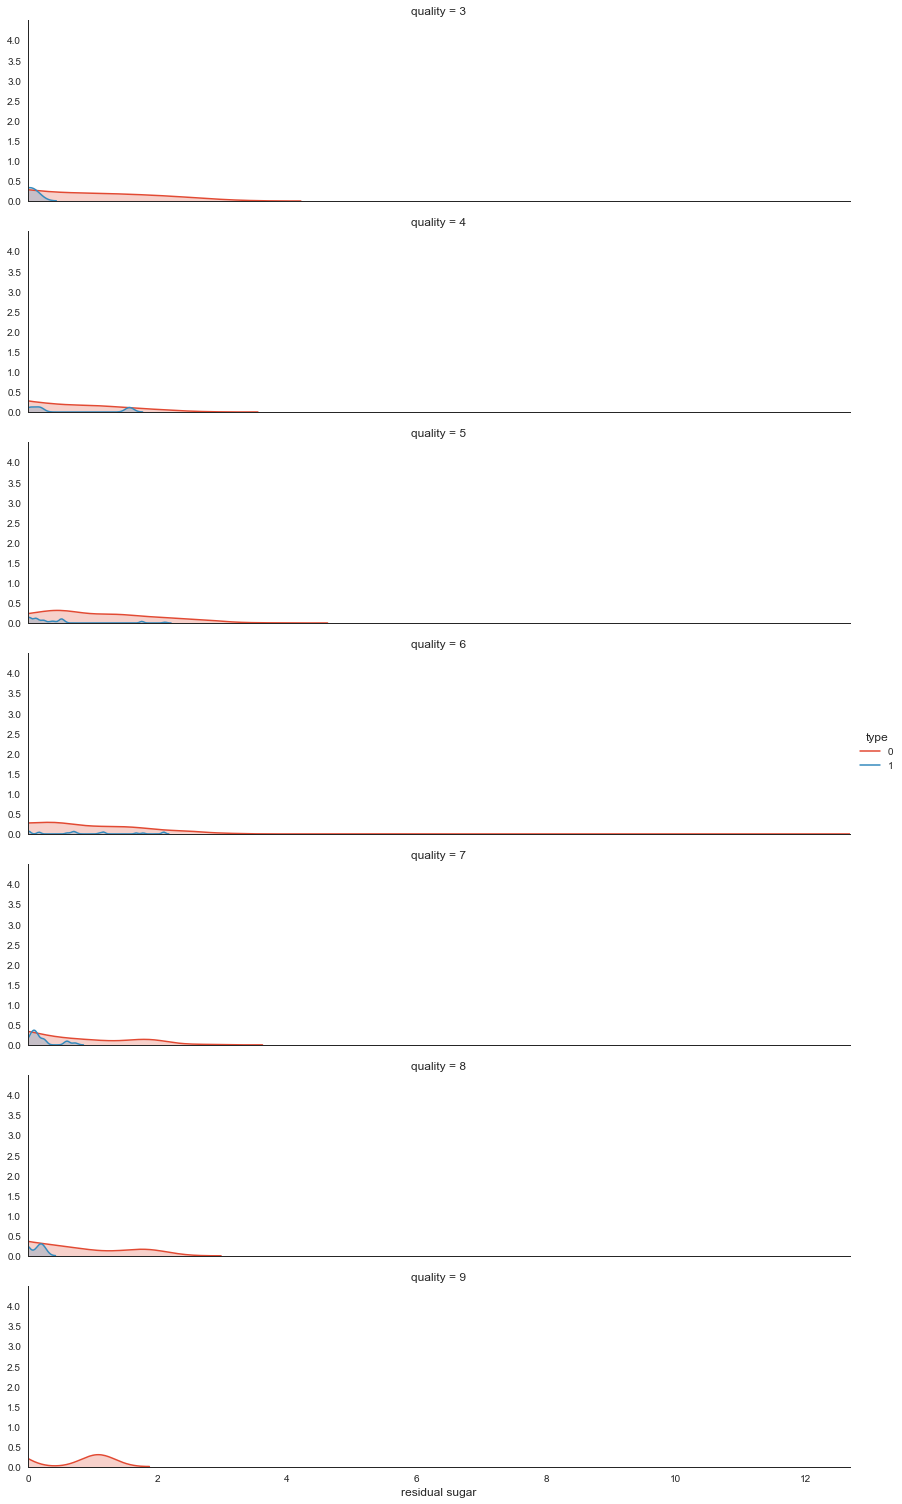

In [48]:
plot_distribution( df_1 , var = 'residual sugar' , target = 'type' , row = 'quality' )

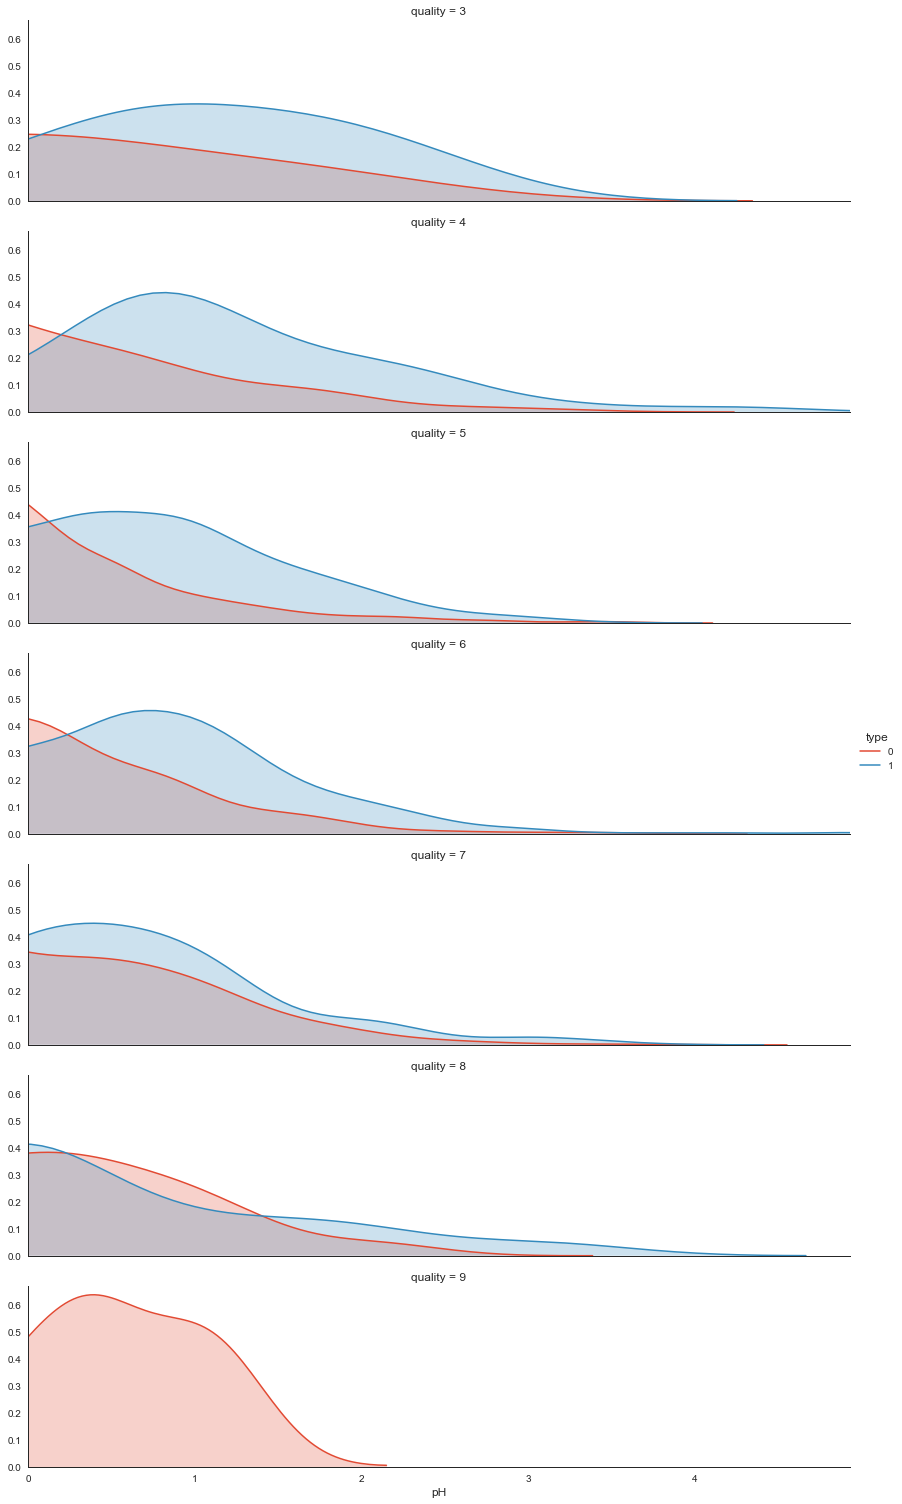

In [49]:
plot_distribution( df_1 , var = 'pH' , target = 'type' , row = 'quality' )

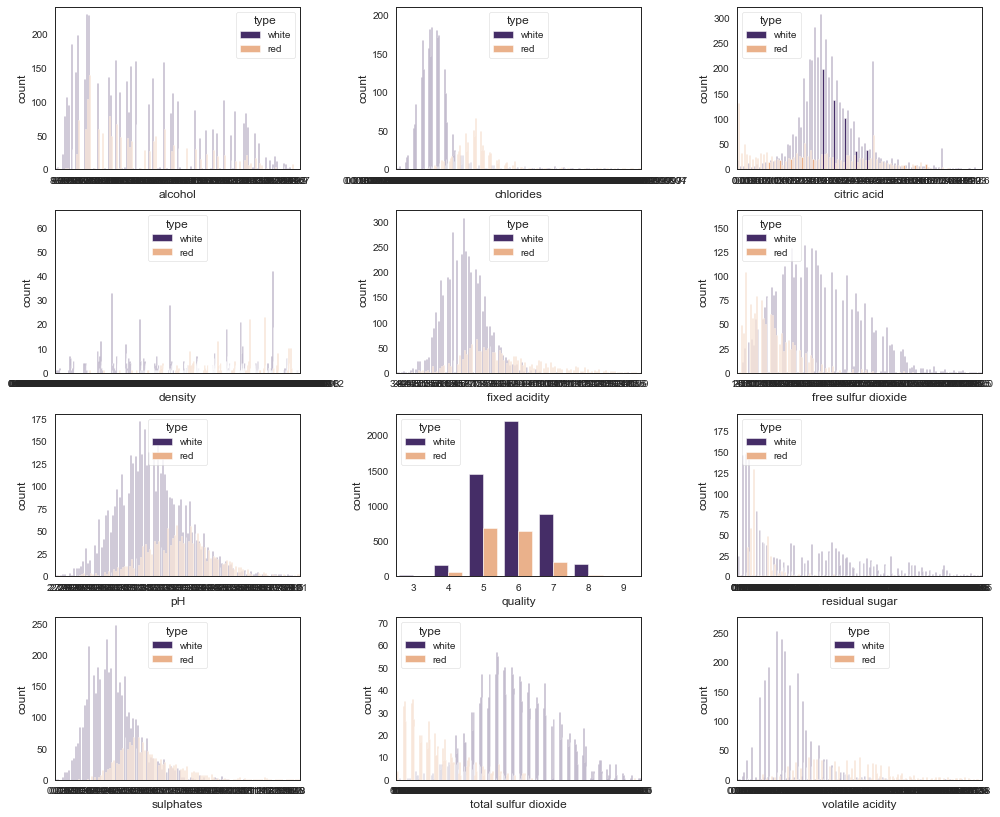

In [17]:
plt.figure(figsize = (14,28))
for x, column in enumerate(df_1.columns.difference(['type'])):
    plt.subplot(10, 3, x+1)
    plt.subplots_adjust(wspace = .5, hspace = 1)
    sns.countplot(x = column, data = df_1, hue = 'type', palette=['#432371',"#FAAE7B"])
    plt.tight_layout()

### 2.4.4 Категориальный признак  - тип вина
Мы также можем посмотреть на категориальную переменную и свзь с качеством

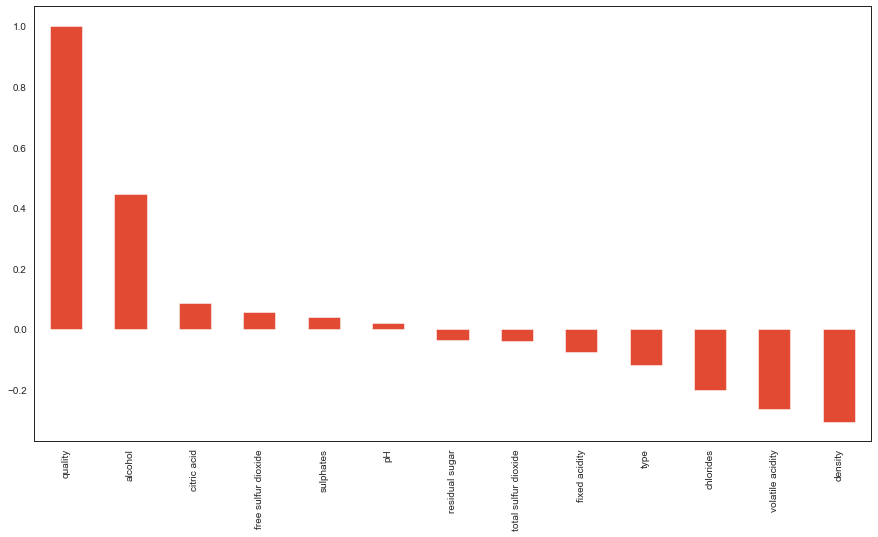

In [47]:
plt.figure(figsize=(15,8))
df_1.corr()['quality'].sort_values(ascending = False).plot(kind='bar')

## 2.4.5 выбросы

<Figure size 1440x360 with 0 Axes>

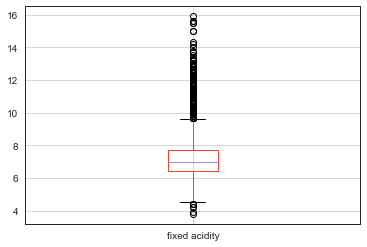

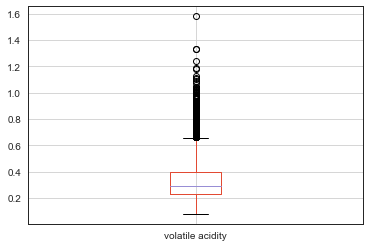

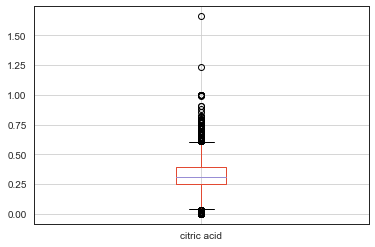

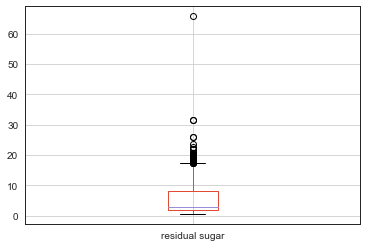

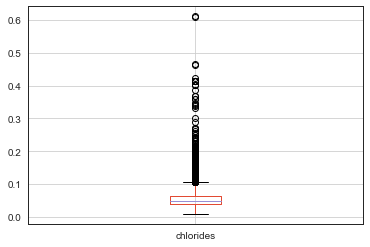

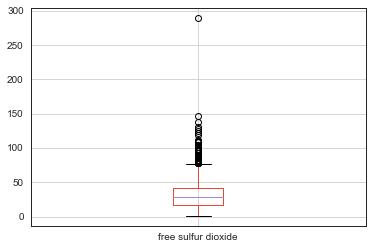

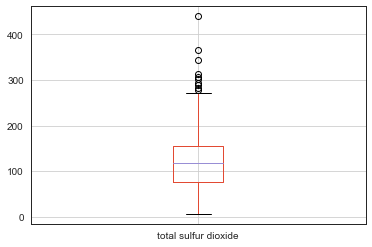

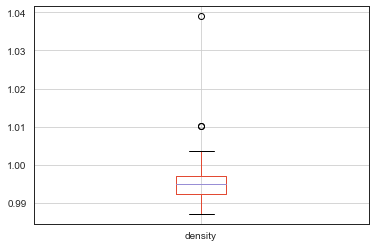

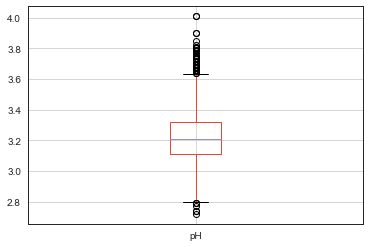

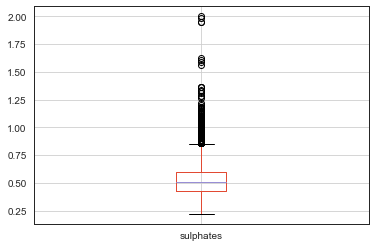

In [18]:
to_outliers = df_1[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
                            'free sulfur dioxide', 'total sulfur dioxide', 'density',
                            'pH', 'sulphates']]

plt.figure(figsize = (20,5))
for i in to_outliers:
    df_1[[i]].plot(kind = 'box', grid = True)

Дополнительно для оценки списка возможных выбросов выведем по каждому признаку подсчет уникальных значений 
с сортировкой по возрастанию, что также позволит увидеть единичные и нетипичные отклонения.

In [19]:
for i in to_outliers:
    print(df_1[i].value_counts(ascending=True).to_frame())

       fixed acidity
6.45               1
14.20              1
13.80              1
15.90              1
14.30              1
...              ...
6.90             279
7.00             282
6.40             305
6.60             326
6.80             354

[106 rows x 1 columns]
       volatile acidity
0.865                 1
0.565                 1
1.185                 1
1.130                 1
0.805                 1
...                 ...
0.220               235
0.250               238
0.260               255
0.240               265
0.280               286

[187 rows x 1 columns]
      citric acid
1.23            1
0.99            1
0.86            1
0.75            1
1.66            1
...           ...
0.26          257
0.49          283
0.32          289
0.28          301
0.30          337

[89 rows x 1 columns]
       residual sugar
20.30               1
8.95                1
3.15                1
14.05               1
14.15               1
...               ...
1.20              1

# 3. Data Preparation

## 3.1 Категориальные переменные должны быть преобразованы в числовые переменные

In [20]:
#replace
df_1['type'].replace(to_replace='red', value=1, inplace=True)
df_1['type'].replace(to_replace='white',  value=0, inplace=True)

In [21]:
df_1

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,0,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,0,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,0,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,0,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,1,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,1,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,1,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,1,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


## 3.2 Заполнить пропущенные значения в переменных
Большинство алгоритмов машинного обучения требуют, чтобы все переменные имели значения, чтобы использовать их для обучения модели. Самый простой метод - заполнить пропущенные значения средним по переменной для всех наблюдений в обучающем наборе.

In [22]:
from sklearn.impute import SimpleImputer
# возьмем только те признаки, в которых есть пропуски
fillna_mean = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'pH', 'sulphates']

for i in fillna_mean:
    imp = SimpleImputer(missing_values = np.nan, strategy='mean') # будем заполнять пропуски средним значением по колонке
    df_1[i] = imp.fit_transform(df_1[[i]])[:, 0]  # тренируем и заполняем
    
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
type                    6497 non-null int64
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null int64
dtypes: float64(11), int64(2)
memory usage: 660.0 KB


In [23]:
#isnull().sum()
df_1.isnull().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [24]:
#get_dummies
df_1 = pd.get_dummies(df_1)
df_1.head(10)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
6,0,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6
7,0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
8,0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
9,0,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,6


In [25]:
#describe()
df_1.describe()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,0.246114,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,0.430779,1.295751,0.164548,0.145231,4.757392,0.035031,17.749400,56.521855,0.002999,0.160637,0.148768,1.192712,0.873255
min,0.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,0.000000,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,0.000000,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,0.000000,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,1.000000,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


## 3.3 Feature Engineering 

In [31]:
from sklearn.preprocessing import StandardScaler

# зададим список признаков, подлежащих стандартизации
cols_to_norm = df_1[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'pH', 'sulphates']]

In [32]:
scaler = StandardScaler()
df_1[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'pH', 'sulphates']] = scaler.fit_transform(df_1[cols_to_norm])

In [33]:
df_1.describe()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6.497000e+03,6.497000e+03,6.497000e+03,6.497000e+03,6.497000e+03,6497.000000,6497.000000,6497.000000,6.497000e+03,6.497000e+03,6497.000000,6497.000000
mean,0.246114,-1.362001e-15,3.085850e-15,2.163030e-16,-4.138345e-16,3.350748e-16,30.525319,115.744574,0.994697,-3.173765e-15,-1.221826e-15,10.491801,5.818378
std,0.430779,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,17.749400,56.521855,0.002999,1.000077e+00,1.000077e+00,1.192712,0.873255
min,0.000000,-2.636958e+00,-1.578333e+00,-2.194751e+00,-1.018352e+00,-1.342973e+00,1.000000,6.000000,0.987110,-3.102860e+00,-2.092106e+00,8.000000,3.000000
25%,0.000000,-6.302460e-01,-6.666730e-01,-4.732259e-01,-7.660934e-01,-5.150623e-01,17.000000,77.000000,0.992340,-6.748377e-01,-6.804067e-01,9.500000,5.000000
50%,0.000000,-1.671586e-01,-3.020089e-01,-6.005986e-02,-5.138350e-01,-2.581246e-01,29.000000,118.000000,0.994890,-5.226785e-02,-1.426163e-01,10.300000,6.000000
75%,0.000000,3.731101e-01,3.665421e-01,4.908282e-01,5.582634e-01,2.557510e-01,41.000000,156.000000,0.996990,6.325590e-01,4.623978e-01,11.300000,6.000000
max,1.000000,6.701972e+00,7.538271e+00,9.236175e+00,1.268769e+01,1.584331e+01,289.000000,440.000000,1.038980,4.928291e+00,9.873729e+00,14.900000,9.000000


# 4. Моделирование
Теперь мы выберем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

## 4.1 Выбор модели
Хорошей отправной точкой является логистическая регрессия.

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X = df_1.drop(columns='quality')

y = df_1['quality']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=500)

In [38]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [39]:
model.score(X_train, y_train)

0.5283817587069464

In [40]:
model.score(X_test, y_test)

0.51

С использованием логистической регрессии качество предсказаний получилось невысоким. Используем DecisionTreeClassifier, т.к. целевая переменная является дискретной

## 4.2 Обучение модели

Acuracy : 61.07692307692307
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.26      0.28      0.27        46
           5       0.67      0.68      0.67       420
           6       0.67      0.65      0.66       579
           7       0.50      0.51      0.51       221
           8       0.25      0.25      0.25        32
           9       0.00      0.00      0.00         0

    accuracy                           0.61      1300
   macro avg       0.34      0.34      0.34      1300
weighted avg       0.62      0.61      0.61      1300

Confusion Matrix


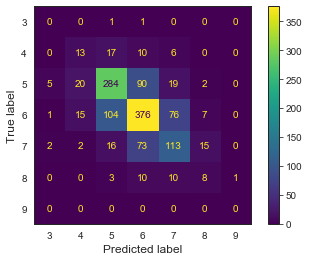

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc,roc_curve,f1_score,classification_report, plot_confusion_matrix
dt = DecisionTreeClassifier(random_state=73)
dt.fit(X_train,y_train)
dt_predict = dt.predict(X_test)

dt_acc_score = accuracy_score(y_test, dt_predict)
print("Acuracy :", dt_acc_score*100)
plot_confusion_matrix(dt,X_test,y_test)
print(classification_report(y_test, dt_predict))
print("Confusion Matrix")

Качество выше,чем на регрессии. 

Acuracy : 69.84615384615384
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.86      0.13      0.23        46
           5       0.72      0.78      0.75       420
           6       0.67      0.79      0.72       579
           7       0.73      0.50      0.60       221
           8       1.00      0.25      0.40        32

    accuracy                           0.70      1300
   macro avg       0.66      0.41      0.45      1300
weighted avg       0.71      0.70      0.68      1300

Confusion Matrix


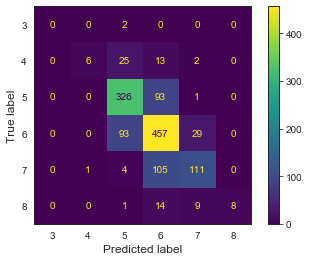

In [42]:
from sklearn.ensemble import RandomForestClassifier
dt = RandomForestClassifier(random_state=73,n_jobs=-1)
dt.fit(X_train,y_train)
dt_predict = dt.predict(X_test)

dt_acc_score = accuracy_score(y_test, dt_predict)
print("Acuracy :", dt_acc_score*100)
plot_confusion_matrix(dt,X_test,y_test)
print(classification_report(y_test, dt_predict))
print("Confusion Matrix")

Качество улучшилось.

# 5. Оценка
Теперь мы собираемся оценить модель

## 5.1 Модель
Мы можем оценить точность модели, используя набор для валидации, где мы знаем фактический результат. Этот набор данных не использовался для обучения, поэтому он абсолютно новый для модели.

Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если разница между ними значительна, это свидетельствует о переобучении. Мы стараемся избегать этого, потому что это означает, что модель не будет хорошо обобщаться на новые данные (будет работать плохо)

In [43]:
classifier =[ DecisionTreeClassifier(random_state=73),
            RandomForestClassifier(random_state=73,n_jobs=-1)]

In [44]:
classifier_columns = []
classifier_compare = pd.DataFrame(columns = classifier_columns)

In [45]:
row_index = 0
for i in classifier:
    y_pred = i.fit(X_train, y_train).predict(X_test)
    new_y=[int(j) for j in y_pred]
   
    classifier_name = i.__class__.__name__
    classifier_compare.loc[row_index,'Classifier Name'] = classifier_name
    classifier_compare.loc[row_index, 'Classifier Train Accuracy'] = round(i.score(X_train, y_train), 4)
    classifier_compare.loc[row_index, 'Classifier Test Accuracy'] = round(i.score(X_test, y_test), 4)
    classifier_compare.loc[row_index, 'Classifier Precission'] = precision_score(y_test, y_pred,average='weighted')
    classifier_compare.loc[row_index, 'Classifier Recall'] = recall_score(y_test, y_pred,average='weighted')
    classifier_compare.loc[row_index, 'Classifier F1 score'] = f1_score(y_test, y_pred,average='weighted')
    row_index+=1
    
classifier_compare.sort_values(by = ['Classifier Test Accuracy'], ascending = False, inplace = True)    
classifier_compare

,Classifier Name,Classifier Train Accuracy,Classifier Test Accuracy,Classifier Precission,Classifier Recall,Classifier F1 score
1,RandomForestClassifier,1.0,0.6985,0.711069,0.698462,0.683706
0,DecisionTreeClassifier,1.0,0.6108,0.616048,0.610769,0.613299


Random Forest - получилась лучшая модель для предсказания качества вина. Random Forest используют метод начальной загрузки (пакетирования) для обучения модели на обучающем наборе.

DecisionTree может иметь более высокую дисперсию (переобучение), но в Random Forest генерируются несколько деревьев. Хотя набор данных имеет низкую размерность, случайные леса полезны для наборов данных большой размерности.

# 6. Развертывание

Развертывание в данном означает публикацию полученного прогноза в таблицу лидеров Kaggle.

In [46]:
y_pred = i.fit(X_train, y_train).predict(X_test)
test = pd.DataFrame( y_pred )
test.shape
test.head()
test.to_csv( 'wine_pred.csv' , index = False )